# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# читаем данные из .csv файла с помощью метода read_csv()
data = pd.read_csv('/datasets/users_behavior.csv')
# выведем первые 10 строк таблицы с помощью метода head()
display(data.head(10))
# с помощью метода info() изучим структуры таблицы: типы данных, количество строк, столбцов, пропущенных данных.
data.info()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [3]:
# преобразуем типы данных в числах звонков и сообщений в целочисленные
data['calls'] = data['calls'].astype('Int64')
data['messages'] = data['messages'].astype('Int64')
# определим общее число явных дубликатов
data.duplicated().sum()
# в датасете все значения числовые, неявных дубликатов быть не должно

0

In [4]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


## Разбейте данные на выборки

Один датасет, делим его на 3 части: на обучаемую(60%), валидационную (20%) и тестовую (20%)

In [5]:
features = data.drop('is_ultra', axis=1)
target = data['is_ultra']
# разделение проведём с помощью функции train_test_split библиотеки sklearn
# деление на тестовую и обучаему+валидационную выборки
data_x, x_test, data_y, y_test = train_test_split(features, target, test_size=0.2, random_state=12345)
# разделение обучаемой и валидационной выборок
x_train, x_valid, y_train, y_valid = train_test_split(data_x, data_y, test_size=0.25, random_state=12345)

#Проверка разделения   
split_list = [x_train, y_train, x_valid, y_valid, x_test, y_test]
for i in split_list:
    res = len(i)/len(data)
    print('Доля выборки:', res, ', Количество строк и столбцов:', i.shape)

Доля выборки: 0.5998755444928439 , Количество строк и столбцов: (1928, 4)
Доля выборки: 0.5998755444928439 , Количество строк и столбцов: (1928,)
Доля выборки: 0.2000622277535781 , Количество строк и столбцов: (643, 4)
Доля выборки: 0.2000622277535781 , Количество строк и столбцов: (643,)
Доля выборки: 0.2000622277535781 , Количество строк и столбцов: (643, 4)
Доля выборки: 0.2000622277535781 , Количество строк и столбцов: (643,)


## Исследуйте модели

### Решающее дерево
Инициируем модель решающего дерева **DecisionTreeClassifier**

**Выделим 5 основных гиперпараметров для настройки модели:**
- max_depth - максимальная глубина древа
- min_samples_split - минимальное количество объектов в узле
- min_samples_leaf - минимальное количество объектов в листе
- criterion ("gini" или "entropy") - функция измерения качества разделения
- splitter ("best" или "random") - стратегия, используемая для выбора разделения в каждом узле

Критерием проверки качества модели будет не только доля правильных ответов **accuracy**, но и время, затреченное на поиск 
оптимальных гиперпараметров

In [6]:
# best_dtc_param и best_dtc_accuracy хранят, при наивысшой точности, параметры модели и саму точность
best_dtc_param = None
best_dtc_accuracy = 0
# проходим в циклах по всем выбранным гиперпараметрам, общее число шагов не более 20000, 
# время затраченное процессором intel CORE i3 не более 2 мин 
for max_depth in range(2, 19):
    for min_samples_split in range(2, 19): 
        for min_samples_leaf in range(1, 18):
            for criterion in ['gini', 'entropy']:
                for splitter in ['best', 'random']:
                    # вызываем модель с текущими гиперпараметрами
                    model_dtc = DecisionTreeClassifier(
                                random_state=12345, max_depth=max_depth, min_samples_split=min_samples_split, 
                                min_samples_leaf=min_samples_leaf, criterion=criterion, splitter=splitter)
                    # обучение модели на тренировочной выборке
                    model_dtc.fit(x_train, y_train)
                    # испытание модели на валидационной выбоке
                    dtc_predictions = model_dtc.predict(x_valid)
                    # вычисление точности модели методом accuracy_score
                    dtc_accuracy = accuracy_score(y_valid, dtc_predictions)
                    # если текущее значение точности выше предыдущего лучшего значения, 
                    # сохраняем параметры модели и текущую точность
                    if dtc_accuracy > best_dtc_accuracy:
                        best_dtc_param = [max_depth, min_samples_split, min_samples_leaf, criterion, splitter]
                        best_dtc_accuracy = dtc_accuracy
                    else:
                        break
# вывод наилучшей точности и параметров модели.
print('''Максимальная доля правильных ответов: {}
Гиперпараметры лучшей модели:
   max_depth = {}
   min_samples_split = {}
   min_samples_leaf = {}
   criterion = {}
   splitter = {} '''.format(round(best_dtc_accuracy, 4), best_dtc_param[0],
                             best_dtc_param[1], best_dtc_param[2], best_dtc_param[3], best_dtc_param[4]
                            ))

Максимальная доля правильных ответов: 0.7978
Гиперпараметры лучшей модели:
   max_depth = 10
   min_samples_split = 18
   min_samples_leaf = 8
   criterion = gini
   splitter = best 


В поиске оптимального решения Питон перебрал **17х17х17х2х2 = 19652 вариантов, за ~ 75 сек.**

Данная модель отлично удовлетворяет условиям задания. 
**Посмотрим результаты других моделей.**

### Случайный лес
Инициируем модель случайного леса **RandomForestClassifier**

**Выделим 5 основных гиперпараметров для настройки модели:**
- n_estimators - количество деревьев
- max_depth - максимальная глубина древа
- min_samples_split - минимальное количество объектов в узле
- min_samples_leaf - минимальное количество объектов в листе
- criterion ("gini" или "entropy") - функция измерения качества разделения

Критерием проверки качества модели всё так же будет доля правильных ответов **accuracy** и время поиска оптимальных гиперпараметров.

In [7]:
best_rfc_param = None
best_rfc_accuracy = 0
# проходим в циклах по всем выбранным гиперпараметрам,общее число шагов не более 20000, 
# время затраченное процессором intel CORE i3 не более 2 мин 
for n_estimators in range(1, 10):
    for max_depth in range(2, 11):
        for min_samples_split in range(2, 11):
            for min_samples_leaf in range(1, 10):
                for criterion in ['gini', 'entropy']:
                    # инициация модели с текущими гиперпараметрами
                    model_rfc = RandomForestClassifier(
                                random_state=12345, n_estimators=n_estimators, max_depth=max_depth,
                                min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                criterion=criterion)
                    # обучение модели на тренировочной выборке
                    model_rfc.fit(x_train, y_train)
                    # поиск предсказаний модели на валидационной выбоке
                    rfc_predictions = model_rfc.predict(x_valid)
                    # вычисление точности модели методом accuracy_score
                    rfc_accuracy = accuracy_score(y_valid, rfc_predictions)
                    # если текущее значение точности выше предыдущего лучшего значения, 
                    # сохраняем параметры модели и текущую точность
                    if rfc_accuracy > best_rfc_accuracy:
                        best_rfc_param = [n_estimators, max_depth, min_samples_split, min_samples_leaf, criterion]
                        best_rfc_accuracy = rfc_accuracy
                    else:
                        break
                        
# вывод наилучшей точности и параметров модели.
print('''Максимальная доля правильных ответов: {}
Гиперпараметры лучшей модели:
   n_estimators = {}
   max_depth = {}
   min_samples_split = {}
   min_samples_leaf = {}
   criterion = {} '''.format(round(best_rfc_accuracy, 4), best_rfc_param[0],
                            best_rfc_param[1], best_rfc_param[2], 
                            best_rfc_param[3], best_rfc_param[4]
                            ))

Максимальная доля правильных ответов: 0.8056
Гиперпараметры лучшей модели:
   n_estimators = 3
   max_depth = 8
   min_samples_split = 3
   min_samples_leaf = 1
   criterion = gini 


В поиске оптимального решения Питон перебрал 9х9х9х9х2 = 13122 варианта за ~ 100 сек.

Точность в модели случайного леса удалось увеличить на ~ 0.8% при временных затратах +30%, по сравнению с моделями **"Решающее дерево"**.

### Логистическая регрессия
Инициируем модель логистической регрессии **LogisticRegression**

**Выделим основные гиперпараметры для настройки модели:**
 - max_iter - инверсия силы регуляризации (значеня от 100 до 10000 с шагом 100)
 - solver - тип решения ('lbfgs' или 'liblinear')
 
Критерием проверки качества модели будет доля правильных ответов **accuracy**.

In [8]:
# в параметрах best_params и best_accuracy будем хранить наилучшие параметры для модели и наивысшую точность соответственно
best_lr_param = None
best_lr_accuracy = 0

for max_iter in range(100, 10000, 100):
    for solver in ['lbfgs', 'liblinear']:
        # инициация модели с текущими гиперпараметрами
        model_lr = LogisticRegression(random_state=12345,  max_iter=max_iter, solver=solver)
        # обучение модели на тренировочной выборке
        model_lr.fit(x_train, y_train)
        # поиск предсказаний модели на валидационной выбоке
        lr_predictions = model_lr.predict(x_valid)
        # вычисление точности модели методом accuracy_score
        lr_accuracy = accuracy_score(y_valid, lr_predictions)
        # если текущее значение точности выше предыдущего лучшего значения, 
        # сохраняем параметры модели и текущую точность
        if lr_accuracy > best_lr_accuracy:
            best_lr_param = [max_iter, solver]
            best_lr_accuracy = lr_accuracy
        else:
            break
        
# вывод наилучшей точности и параметров модели.
print('''Максимальная доля правильных ответов: {}
Гиперпараметры лучшей модели:
   C = {}
   solver = {} '''.format(round(best_lr_accuracy, 4), best_lr_param[0], best_lr_param[1]))

Максимальная доля правильных ответов: 0.7263
Гиперпараметры лучшей модели:
   C = 100
   solver = lbfgs 


Логистическая регрессия даёт сильно меньшую долю правильных ответов (**недостаточную для решения задачи**), чем модели "Решающее дерево" и "Случайный лес", хоть и времени на перебор параметров уходит в разы меньше. 

## Проверьте модель на тестовой выборке

По критерию **accuracy** максимальной доли правильных ответов удалось достичь с моделью **Случайного леса**

**Максимальная доля правильных ответов: 0.8056**

**Гиперпараметры лучшей модели:**
- n_estimators = 3
- max_depth = 8
- min_samples_split = 3
- min_samples_leaf = 1
- criterion = 'gini'

Проведём обучение данной модели **на всех доступных данных** (обучающие + валидационные) и вычислим точность на тестовой выборке.

In [9]:
model_rfc = RandomForestClassifier(random_state=12345,
                                      n_estimators=3, max_depth=8,
                                      min_samples_split=3,
                                      min_samples_leaf=1,
                                      criterion='gini')
model_rfc.fit(data_x, data_y)
rfc_predictions = model_rfc.predict(x_test)
rfc_accuracy = accuracy_score(y_test, rfc_predictions)
print('Доля правильных ответов модели на тестовой выборке: {}'.format(round(rfc_accuracy, 4)))

Доля правильных ответов модели на тестовой выборке: 0.7885


Доля правильных ответов модели на тестовой выборке **упала примерно на 1.7% пункта**.

Проверим вторую по доле правильных ответов (accuracy = 0.7978) модель **"Решающее дерево"** с гиперпараметрами:
- max_depth = 10
- min_samples_split = 18
- min_samples_leaf = 8 
- criterion = 'gini'
- splitter = 'best'

In [10]:
model_dtc = DecisionTreeClassifier(random_state=12345, 
                                   max_depth=10, 
                                   min_samples_split=18, 
                                   min_samples_leaf=8, 
                                   criterion='gini', splitter='best')
model_dtc.fit(data_x, data_y)
dtc_predictions = model_dtc.predict(x_test)
dtc_accuracy = accuracy_score(y_test, dtc_predictions)
print('Доля правильных ответов модели на тестовой выборке: {}'.format(round(dtc_accuracy, 4)))

Доля правильных ответов модели на тестовой выборке: 0.7854


Доля правильных ответов модели на тестовой выборке **упала примерно на 1.2% пункта** и приблизилась по точности к модели "Случайный лес".

## (бонус) Проверьте модели на адекватность

###  Поиск более оптимальных решений
Прелагается проверить улучшиться ли предсказание моделей, если посмотреть более широкий диапазон двух основных гиперпараметров Если рост доли правильных ответов будет больше 1%, то можно поставить **вопрос об оптимальности способа первичного поиска** гиперпараметров моделей. 
- Зафиксируем наименее значимые параметры на значениях, найденных в циклах
- создадим словарь из двух параметров и вычисленной доли правильных ответов
- на основании сводной таблицы словарей построим "тепловую карту" доли правильных ответов
- выберем лучшую показатели правильных ответов при наименьших значениях двух основных гиперпараметров
- вычислим разность со значениями доли правильных ответов, полученных в циклах

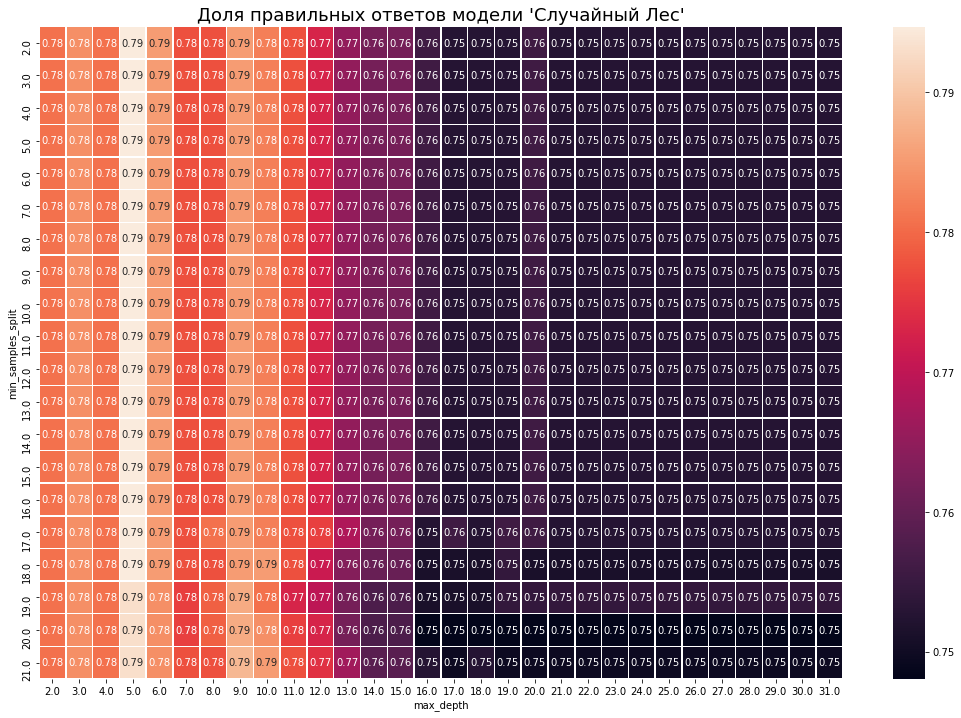

In [11]:
data_dtc_accuracy = pd.DataFrame(columns=['max_depth', 'min_samples_split', 'accuracy'])
for max_depth in range(2, 32):
    for min_samples_split in range(2, 22):
        model_dtc = DecisionTreeClassifier(random_state=12345, 
                                   max_depth=max_depth, 
                                   min_samples_split=min_samples_split, 
                                   min_samples_leaf=8, criterion='gini', splitter='best')
        model_dtc.fit(data_x, data_y)
        dtc_predictions = model_dtc.predict(x_test)
        dtc_accuracy = accuracy_score(y_test, dtc_predictions)
        data_dtc_accuracy = data_dtc_accuracy.append({'max_depth': max_depth,
                                          'min_samples_split': min_samples_split,
                                          'accuracy': dtc_accuracy}, 
                                          ignore_index=True)

pivot_dtc_accuracy = data_dtc_accuracy.pivot('min_samples_split', 'max_depth', 'accuracy')
f, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(pivot_dtc_accuracy, annot=True, fmt=".2f", linewidths=.5, ax=ax)
ax.set_title("Доля правильных ответов модели 'Случайный Лес'", fontsize=18)
plt.show()

Есть целый срез (max_depth=5) со значением accuracy = 0.79, выберем точку с наименьшим значением min_samples_split (равным 2).

In [12]:
model_dtc = DecisionTreeClassifier(random_state=12345, 
                                   max_depth=5, 
                                   min_samples_split=2, 
                                   min_samples_leaf=8, 
                                   criterion='gini', splitter='best')
model_dtc.fit(data_x, data_y)
dtc_predictions = model_dtc.predict(x_test)
dtc_accuracy = accuracy_score(y_test, dtc_predictions)
print('Доля правильных ответов модели на тестовой выборке: {}'.format(round(dtc_accuracy, 4)))

Доля правильных ответов модели на тестовой выборке: 0.7947


Доля правильных ответов модели на тестовой выборки с новыми параматрами max_depth и min_samples_split **увеличилась примерно на 0.9% пункта**.

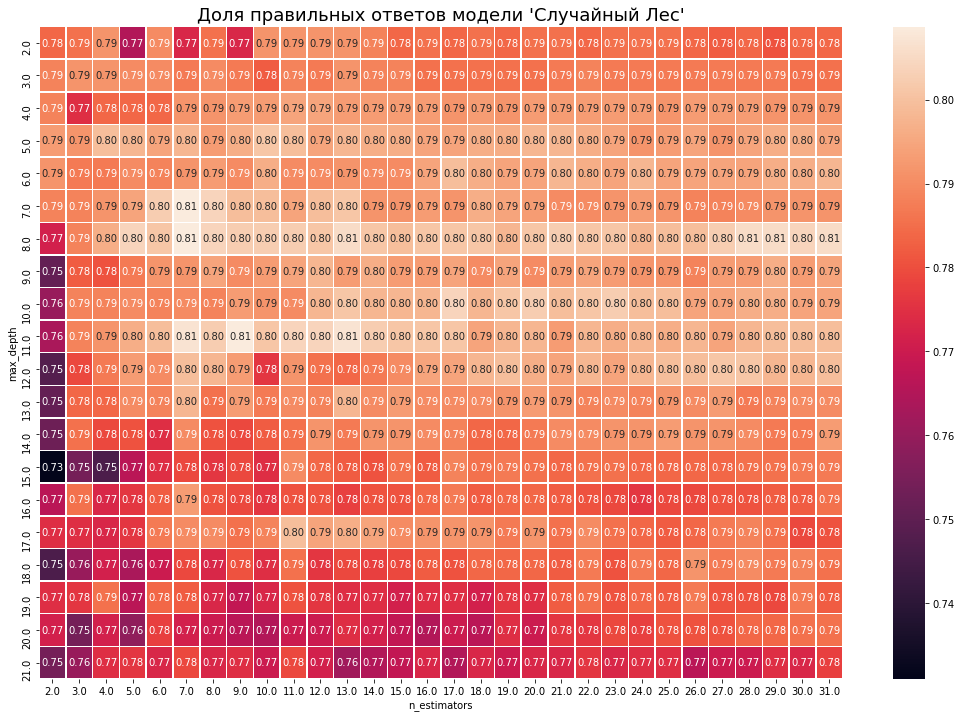

In [13]:
data_rfc_accuracy = pd.DataFrame(columns=['n_estimators', 'max_depth', 'accuracy'])
for n_est in range(2, 32):
    for m_depth in range(2, 22):
        model_rfc = RandomForestClassifier(random_state=12345, 
                                      n_estimators=n_est,
                                      max_depth=m_depth, 
                                      min_samples_split=3, min_samples_leaf=1, criterion='gini')
        model_rfc.fit(data_x, data_y)
        rfc_predictions = model_rfc.predict(x_test)
        rfc_accuracy = accuracy_score(y_test, rfc_predictions)
        data_rfc_accuracy = data_rfc_accuracy.append({'n_estimators': n_est,
                                          'max_depth': m_depth,
                                          'accuracy': rfc_accuracy}, 
                                          ignore_index=True)

pivot_rfc_accuracy = data_rfc_accuracy.pivot('max_depth', 'n_estimators', 'accuracy')
f, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(pivot_rfc_accuracy, annot=True, fmt=".2f", linewidths=.5, ax=ax)
ax.set_title("Доля правильных ответов модели 'Случайный Лес'", fontsize=18)
plt.show()

Есть 6 точек со значением accuracy = 0.81, выберем точку с наименьшими значениями n_estimators и max_depth (равными 7).

In [14]:
model_rfc = RandomForestClassifier(random_state=12345,
                                      n_estimators=7, max_depth=7,
                                      min_samples_split=3,
                                      min_samples_leaf=1,
                                      criterion='gini')
model_rfc.fit(data_x, data_y)
rfc_predictions = model_rfc.predict(x_test)
rfc_accuracy = accuracy_score(y_test, rfc_predictions)
print('Доля правильных ответов модели на тестовой выборке: {}'.format(round(rfc_accuracy, 4)))

Доля правильных ответов модели на тестовой выборке: 0.8087


Доля правильных ответов модели на тестовой выборки с новыми параматрами max_depth и min_samples_split **увеличилась примерно на 2% пункта**. Очень много, возможно не стоит перебирать в первом цикле сразу весь пул параметров и двигаться строго постепенно в порядке, указанном в руководстве по sklearn

### Проверка моделей на адекватность
**Мягкий критерий**: Исходя из вероятности выбора тарифа в 50%, любая модель с долей правильных ответов больше 0.5 - адекватна

**Жёсткий критерий**: Задать порог адекватности можно и с помощью класса **DummyClassifier**

**Объяснения метода переведены из руководства по sklearn https://scikit-learn.org/**
- **DummyClassifier** делает прогнозы, основанные на игнорировании входных функций.
- Этот классификатор служит простой базой для сравнения с другими более сложными классификаторами.
- Конкретное поведение базовой линии выбирается с помощью параметра стратегии.
- Стратегия предсказания 'most_frequent' всегда возвращает наиболее часто встречающуюся метку класса в наблюдаемом аргументе функции fit.

In [18]:
from sklearn.dummy import DummyClassifier

model_dc = DummyClassifier(strategy='most_frequent', random_state=12345)
model_dc.fit(data_x, data_y)

score = model_dc.score(x_test, y_test)
print('Доля правильных ответов модели Dummy на всей выборке:', round(score, 1))

Доля правильных ответов модели Dummy на всей выборке: 0.7


У всех проверенных выше классов **доля правильных ответов выше и 0.5, и 0.7**, таким образом все рассматриваемые выше **модели адекватны по двум критериям**.

## Общий вывод
- Данные успешно загружены и проанализированы.
Пропусков не обнаружено, типы данных преобразованы в соответствии с хранимой информацией.

- Были проанализированы основные классификационные модели: Решающее дерево, Случайный лес, Логистическая регрессия
- Модели обучены на различных сочетаниях гиперпараметров, для каждого набора значений гиперпараметров определена доля правильных ответов модели на валидационной выборке.
- Получены доли правильных ответов для всех трёх основных классов моделей (accuracy равны соответственно 0.7978, 0.8056 и 0.7263). Максимальное значение было достигнуто для модели Случайного леса. Зафиксировано время получения этих параметров на компьютере с процессором intel core i3 (загрузка ЦП 95 - 100%).
- Модели 'Случайный лес' и 'Решающее дерево' с наилучшими гиперпараметрами были проанализированы на тестовой выборке. Доли правильных ответов упали на 1,7 и на 1,2 процентных пунктов соответственно (и заметно сравнялись).
- Было проведено уточнение гиперпараметров для двух вышеуказанных ранее классов моделей при фиксированных значениях второстепенных параметров, результаты были представлены в виде тепловых карт и выбраны максимальные значения доли правильных ответов при минимальных значениях соответствующих основных гиперпараметров. 
- Максимальное значение доли правильных ответов остаётся за моделью класса 'Случайный лес' **(accuracy достигает 0.8087)** при значениях двух основных гиперпараметров: max_depth=7 и n_estimators=7.
- Модели проверены на адекватность с помощью вероятностного критерия и простейшего классификатора **DummyClassifier**.